<a href="https://colab.research.google.com/github/Quantum-Syntax/Emergency-Admission-Prediction/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
COMP 432 Course Project
Author: Tianmu Yang, ID: 40103506
Dataset source: EMRBots Synthetic Electronic Medical Record Dataset by Uri Kartoun，available at: https://figshare.com/articles/dataset/EMRBots_a_100_000-patient_database/7040198?file=12941429
Declaration: This project’s planning, methodology design, implementation, and report writing were carried out independently by the author. All external resources have been properly cited.
Any use of Large Language Models (LLMs) was strictly limited to debugging support and linguistic polishing.
"""

# Download and unzip the dataset for the project.
!gdown 1-LZcbXW6PV8Sf9Yw1_xkazOUK2osztzB
!unzip Original_Dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1-LZcbXW6PV8Sf9Yw1_xkazOUK2osztzB
From (redirected): https://drive.google.com/uc?id=1-LZcbXW6PV8Sf9Yw1_xkazOUK2osztzB&confirm=t&uuid=bcc5c7cd-65e4-4a5d-ad5a-657a68bbe373
To: /content/Original_Dataset.zip
100% 1.52G/1.52G [00:20<00:00, 76.0MB/s]
Archive:  Original_Dataset.zip
  inflating: Original Dataset/AdmissionsCorePopulatedTable.txt  
  inflating: Original Dataset/AdmissionsDiagnosesCorePopulatedTable.txt  
  inflating: Original Dataset/LabsCorePopulatedTable.txt  
  inflating: Original Dataset/PatientCorePopulatedTable.txt  
  inflating: Original Dataset/ReadMe.txt  


In [ ]:
"""
This script imports necessary modules.
"""

# Modules for data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modules for data augmentation and encoder
import math
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader

# Modules for basic machine learning model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Hide warning messages.
import warnings
warnings.filterwarnings("ignore")

In [ ]:
"""
This script performs preprocessing of the EMRBots raw dataset.
Steps include:
1. Loading and cleaning patient demographic data.
2. Merging diagnostic information from admission records.
3. Filtering and aggregating key laboratory results (e.g., WBC, glucose).
4. Calculating patient age and removing records with unknown attributes.
5. Integrating admission records and calculating hospital stay duration.
6. Generating a classification label for admission duration:
   - 0 = ≤3 days (discharged);
   - 1 = 4–10 days (short stay);
   - 2 = >10 days (long stay).
7. Removing records with missing values and exporting the cleaned dataset.

Final output: a cleaned dataset `Dataset_Cleaned.csv` with useful features including demographics, numerical and categorical features, diagnostic codes, lab results (with units),
and a multi-class target label for patient admission prediction.
"""

"""Load and preprocess patient info."""
# Grab the basic patient demographic info.
patients = pd.read_csv("/content/Original Dataset/PatientCorePopulatedTable.txt", sep="\t", dtype={"PatientDateOfBirth": str})

# Compute age.
patients["PatientDateOfBirth"] = pd.to_datetime(patients["PatientDateOfBirth"], errors="coerce")    # Read the date of birth. Convert to NaT if the format is illegal.
patients["Age"] = 2025 - patients["PatientDateOfBirth"].dt.year

# Get rid of patients with unknown race or marital status are unknown.
patients = patients[(patients["PatientRace"] != "Unknown") & (patients["PatientMaritalStatus"] != "Unknown")]

# Select the first 16000 patients for simplicity. A dataset of 15000 samples is enough for this project. 1000 extra examples are reserved just in case there are samples with NaN.
patients = patients.drop(columns=["PatientDateOfBirth"])
patients = patients.head(16000)

"""Merge diagnosis info."""
# Pull diagnosis data (with duplicates).
diagnosis_df = pd.read_csv("/content/Original Dataset/AdmissionsDiagnosesCorePopulatedTable.txt", sep="\t", dtype=str)
diagnosis_df = diagnosis_df.drop_duplicates(subset=["PatientID"])  # Keep the first test result per patient for each creteria.

# Bring over diagnosis info.
patients = pd.merge(
    patients,
    diagnosis_df[["PatientID", "AdmissionID", "PrimaryDiagnosisCode", "PrimaryDiagnosisDescription"]],
    on="PatientID",     # Match with PatientID.
    how="left"       # Keep the info on the left side.
)

"""Pull lab results."""
# Select specific labs we care about (clinical input).
interesting_labs = [
    "CBC: WHITE BLOOD CELL COUNT", "CBC: RED BLOOD CELL COUNT", "CBC: HEMOGLOBIN", "CBC: PLATELET COUNT",
    "METABOLIC: SODIUM", "METABOLIC: POTASSIUM", "METABOLIC: CHLORIDE", "METABOLIC: GLUCOSE",
    "METABOLIC: CREATININE", "METABOLIC: BUN", "METABOLIC: ALBUMIN", "METABOLIC: AST/SGOT", "METABOLIC: ALT/SGPT"
]

# Reading the file in chunks to avoid memory issues. This file is huge!
chunk = pd.read_csv("/content/Original Dataset/LabsCorePopulatedTable.txt", sep="\t", chunksize=100000, dtype=str)

# Loop through the file to search for lab results for selected patient only.
target_patient_ids = set(patients["PatientID"])
filtered_lab_chunks = []

for lab_chunk in chunk:
    labs_sub = lab_chunk[lab_chunk["PatientID"].isin(target_patient_ids)]   # Select lab results for target patients.
    labs_sub = labs_sub[labs_sub["LabName"].isin(interesting_labs)].copy()    # Select insterested labs omly.
    labs_sub["LabDateTime"] = pd.to_datetime(labs_sub["LabDateTime"], errors="coerce")

    # Take first recorded result for each test per patient. Since the same test may be done multiple times for each patient, the result upon admission is selected.
    labs_sub = labs_sub.sort_values("LabDateTime").drop_duplicates(subset=["PatientID", "LabName"], keep="first")
    filtered_lab_chunks.append(labs_sub)

# Concatenate the lab results with the main dataset.
combined_labs = pd.concat(filtered_lab_chunks, ignore_index=True)   # Combine all the chunks.
combined_labs = combined_labs.sort_values("LabDateTime").drop_duplicates(subset=["PatientID", "LabName"], keep="first") # Drop global duplicates.
labs_spreaded = combined_labs.pivot(index="PatientID", columns="LabName", values="LabValue").reset_index()  # Spread the test results horizontally for each patient.
patients = pd.merge(patients, labs_spreaded, on="PatientID", how="left")

# Add units to lab result columns for readability.
lab_units = {
    "CBC: HEMOGLOBIN": "g/dL",
    "CBC: PLATELET COUNT": "10^3/μL",
    "CBC: RED BLOOD CELL COUNT": "10^6/μL",
    "CBC: WHITE BLOOD CELL COUNT": "10^3/μL",
    "METABOLIC: ALBUMIN": "g/dL",
    "METABOLIC: ALT/SGPT": "U/L",
    "METABOLIC: AST/SGOT": "U/L",
    "METABOLIC: BUN": "mg/dL",
    "METABOLIC: CHLORIDE": "mmol/L",
    "METABOLIC: CREATININE": "mg/dL",
    "METABOLIC: GLUCOSE": "mg/dL",
    "METABOLIC: POTASSIUM": "mmol/L",
    "METABOLIC: SODIUM": "mmol/L"
}
patients.rename(columns={name: f"{name} ({unit})" for name, unit in lab_units.items()}, inplace=True)

"""Admission data and labeling"""
# Pull admission records and process dates.
adm_data = pd.read_csv("/content/Original Dataset/AdmissionsCorePopulatedTable.txt", sep="\t", dtype=str)

# Calculate the length of stay (in days).
adm_data["AdmissionStartDate"] = pd.to_datetime(adm_data["AdmissionStartDate"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
adm_data["AdmissionEndDate"] = pd.to_datetime(adm_data["AdmissionEndDate"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
adm_data["StayLength"] = (adm_data["AdmissionEndDate"] - adm_data["AdmissionStartDate"]).dt.total_seconds() / (60*60*24)

# Select the first admission chronologically per patient.
adm_data = adm_data.sort_values("AdmissionStartDate").drop_duplicates(subset=["PatientID"], keep="first")

# Labeling:
# 0: Discharged (<=3 days)
# 1: Short Admission (4 - 10 days)
# 2: Long Admission (> 10 days)
def map_stay_to_label(days_in_hospital):
    if pd.isna(days_in_hospital):   # Filter out NaN.
        return None
    elif days_in_hospital <= 3:
        return 0
    elif days_in_hospital <= 10:
        return 1
    else:
        return 2

adm_data["Label"] = adm_data["StayLength"].apply(map_stay_to_label)

# Format the stay length.
adm_data["AdmissionStartDate"] = adm_data["AdmissionStartDate"].dt.date
adm_data["AdmissionEndDate"] = adm_data["AdmissionEndDate"].dt.date
adm_data["StayLength"] = adm_data["StayLength"].round().astype("Int64")

# Merge in admission info.
adm_essential = adm_data[["PatientID", "AdmissionStartDate", "AdmissionEndDate", "StayLength", "Label"]]
patients = pd.merge(patients, adm_essential, on="PatientID", how="left")

"""Finalization."""
# Drop samples with missing values.
dataset_cleaned = patients.dropna()

# Output final dataset.
dataset_cleaned.to_csv("Dataset_Cleaned.csv", index=False)
print("Cleaned dataset saved to Dataset_Cleaned.csv.")

Cleaned dataset saved to Dataset_Cleaned.csv.


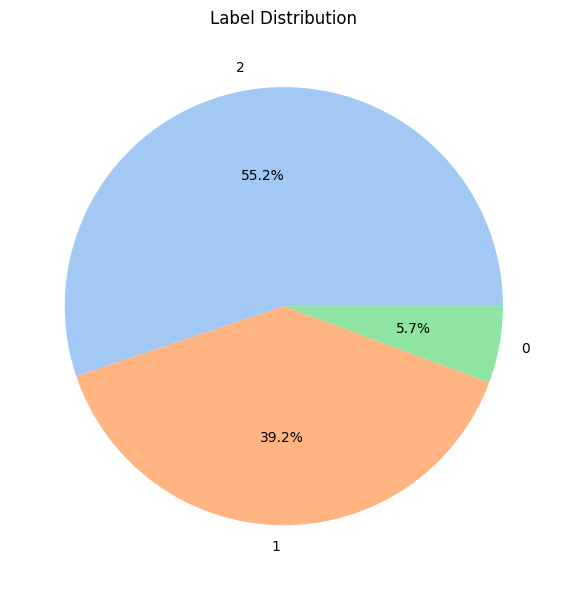

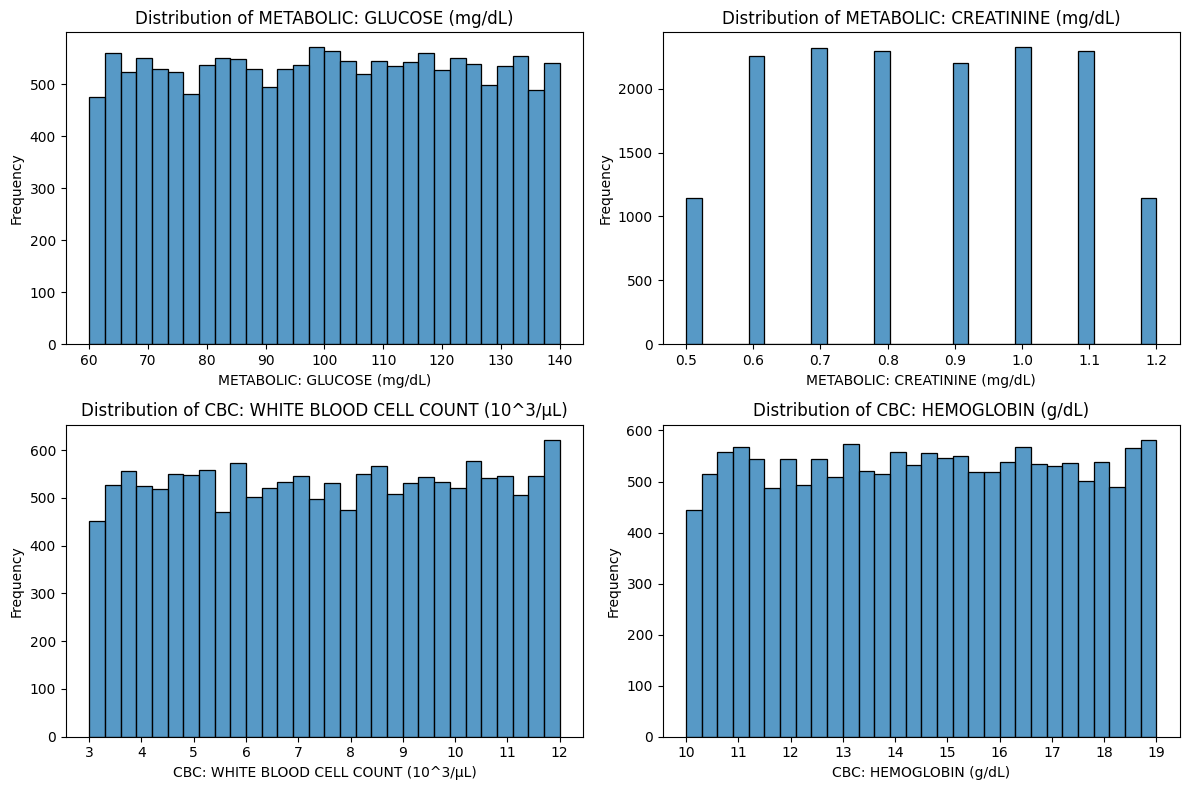

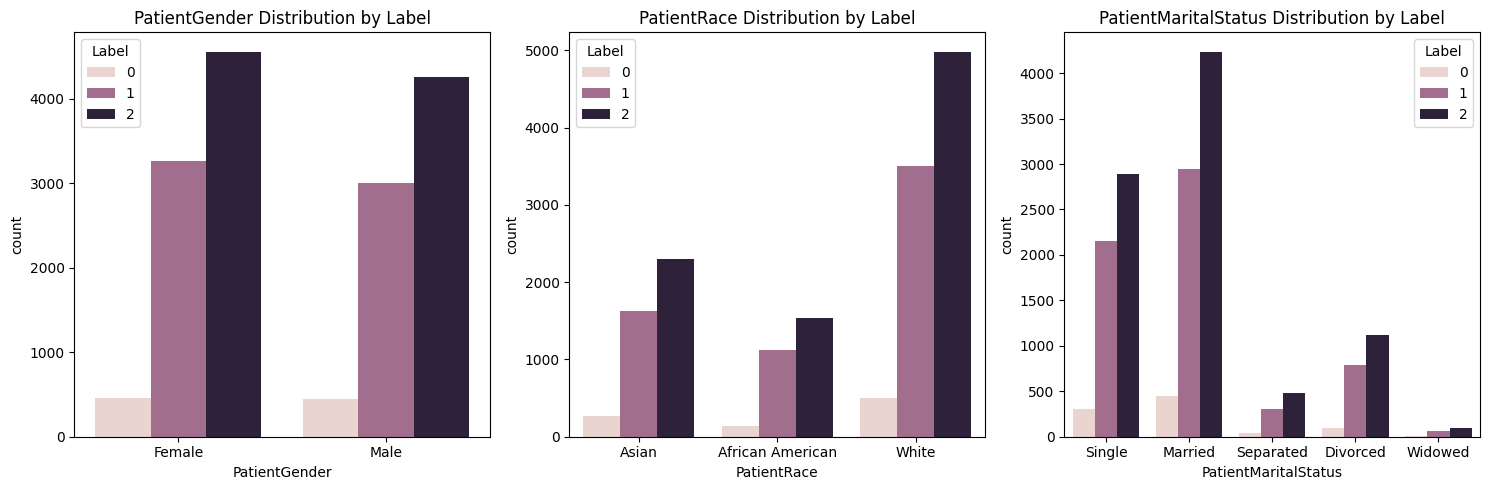

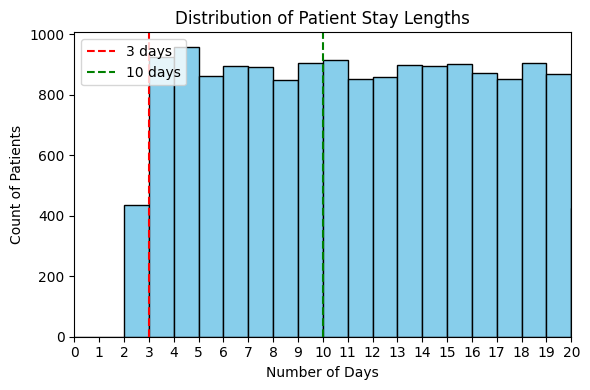

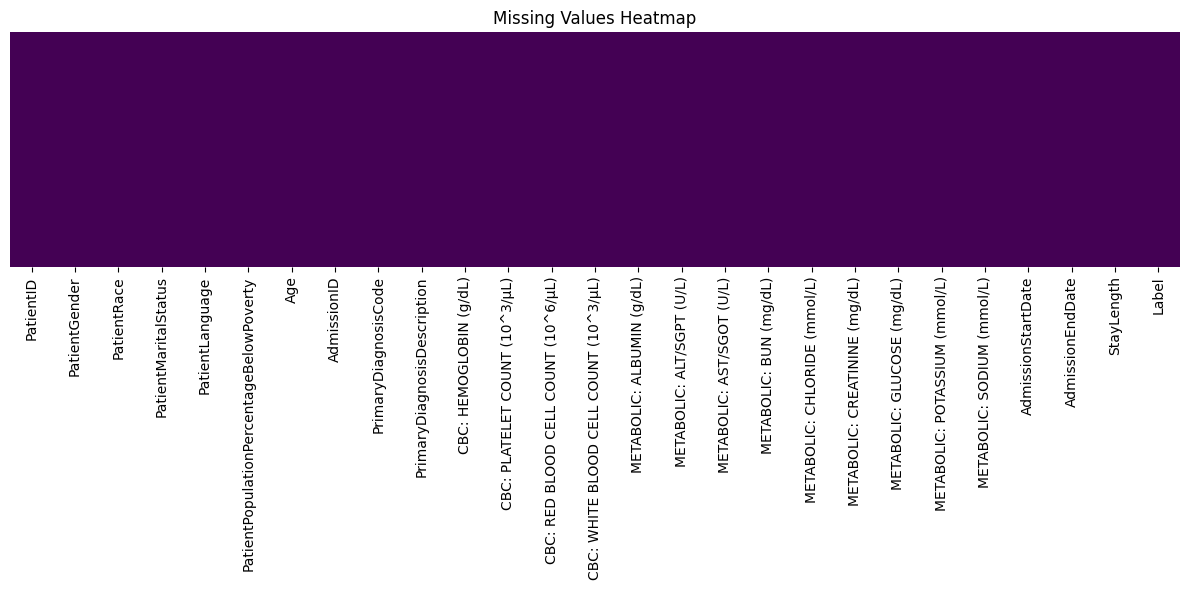

In [ ]:
"""
This script visualizes the cleaned dataset, including the label distribution, key lab features, and demographics.
"""

# Load the cleaned dataset.
dataset = pd.read_csv("Dataset_Cleaned.csv")

# Label distribution as pie chart.
plt.figure(figsize=(6, 6))
label_count = dataset['Label'].value_counts()
plt.pie(
    label_count,
    labels=label_count.index,
    autopct='%1.1f%%',  # This automatically changes the values to percentage, with one decimal place.
    colors=sns.color_palette("pastel") # Pastel keeps it less overwhelming.
)
plt.title("Label Distribution")
plt.tight_layout()  # Auto-arrangement of the plotting
plt.show()

# Distribution of key lab features. Picking a few for visualization. One histogram per metric.
key_lab_metrics = [
    "METABOLIC: GLUCOSE (mg/dL)",
    "METABOLIC: CREATININE (mg/dL)",
    "CBC: WHITE BLOOD CELL COUNT (10^3/μL)",
    "CBC: HEMOGLOBIN (g/dL)",
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows x 2 cols, shared figure
axes = axes.flatten()

for i, lab_metric in enumerate(key_lab_metrics):
    data_to_plot = dataset[lab_metric].dropna()
    sns.histplot(data_to_plot, kde=False, bins=30, ax=axes[i]) # No kde curve, number of bars=30
    axes[i].set_title(f"Distribution of {lab_metric}")
    axes[i].set_xlabel(lab_metric)
    axes[i].set_ylabel("Frequency")

    if i in [2, 3]:
        tick_locs = np.round(np.linspace(data_to_plot.min(), data_to_plot.max(), 10), 1)  # 10个点，保留一位小数
        axes[i].set_xticks(tick_locs)

plt.tight_layout()
plt.show()

# Demographical feature distribution. Checking for possible bias.
demo_features = ["PatientGender", "PatientRace", "PatientMaritalStatus"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, c in enumerate(demo_features):
    sns.countplot(x=c, hue='Label', data=dataset, ax=axes[i])
    axes[i].set_title(f"{c} Distribution by Label")

plt.tight_layout()
plt.show()

# Stay length distribution
plt.figure(figsize=(6, 4))
stay_lengths = dataset["StayLength"].dropna()  # Drop missing values.
bins = np.arange(0, 21 + 1, 1)
plt.hist(stay_lengths, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(3, color='red', linestyle='--', label='3 days') # Bondary between class 1 and 2
plt.axvline(10, color='green', linestyle='--', label='10 days') # Bondary between class 2 and 3
plt.title("Distribution of Patient Stay Lengths")
plt.xlabel("Number of Days")
plt.ylabel("Count of Patients")
plt.xticks(np.arange(0, 21, 1))
plt.xlim(0, 20)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap for dection of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(dataset.isnull(),
            cbar=False, # No color bar.
            yticklabels=False, # No data index.
            cmap='viridis'  # Set color
)
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
def set_seed(seed=42):
    """
    Set the random seed across Python, NumPy, and PyTorch to ensure full reproducibility.

    This function sets seeds for:
    - Python's built-in `random` module
    - NumPy's random generator
    - PyTorch (CPU and all CUDA devices)
    - Python hash randomization (via environment variable)

    It also configures PyTorch's backend to operate deterministically to avoid non-deterministic
    results caused by certain CUDA operations.

    Parameters:
    - seed: int
      The seed value to use. Default is 42.
    """
    random.seed(seed) # Set the random seed for Python's built-in random module.
    np.random.seed(seed) # Set the random seed for NumPy's random number generator.
    torch.manual_seed(seed) # Set the seed for PyTorch's CPU random number generator.
    torch.cuda.manual_seed_all(seed) # Set the same seed for PyTorch's random number generator on all CUDA GPUs.
    os.environ['PYTHONHASHSEED'] = str(seed) # Set Python's hash randomization seed (controls the order in which unordered structures such as sets and dicts are traversed).
    torch.backends.cudnn.deterministic = True # Makes CuDNN perform operations in a deterministic manner.
                          # Prevents different results from each run due to the use of non-deterministic algorithms (such as convolution).
    torch.backends.cudnn.benchmark = False  # Disables CuDNN's automatic algorithm optimization to makes the run more deterministic.

# Set the seed with the default value.
set_seed(42)

In [ ]:
"""
This script loads a pre-cleaned medical dataset and prepares it for supervised/unsupervised machine learning.
The preprocessing includes dropping irrelevant identifier and timestamp columns, label-encoding low-cardinality categorical features, one-hot encoding the primary diagnosis codes (a high-cardinality feature),
and casting all features to float32 for computational efficiency.
The script also creates a copy for use in self-supervised learning tasks, where all caregorical features are label-encoded.
Finally, split the datasets into training and testing sets for both supervised learning and unsupervised learning using stratified sampling to preserve label distribution.
"""

# Load data and drop irrelevant columns.
dataset = pd.read_csv("Dataset_Cleaned.csv")  # May be replaced with the proper path

dataset.drop([
    'PatientID',
    'AdmissionID',
    'AdmissionStartDate',
    'AdmissionEndDate',
    'PrimaryDiagnosisDescription'
], axis=1, inplace=True)

dataset_for_SSL = dataset.copy() # For SSL use

"""
Prepare the dataset for supervised learning.
"""
# Get features and targets.
X = dataset.drop(columns='Label')
y = dataset['Label']

# Label encode categorical features except PrimaryDiagnosisCode.
# Use LabelEncoder for small category features for lighter weight.
catagoricals = X.select_dtypes(include="object").columns.drop("PrimaryDiagnosisCode")

catagory_encoder = {}  # Store the LabelEncoder object (the encoding rules) for restoration of the original category label.

for c in catagoricals:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    catagory_encoder[c] = le  # Storing encoders in case of decoding later

# One-hot encode PrimaryDiagnosisCode. Use One-Hot for large category features for more accuracy, avoid spoofing the "sequential" meaning.
X = pd.get_dummies(X, columns=["PrimaryDiagnosisCode"], prefix="DX")  # Add prefix to one-hot features. "DX" for "diagnosis".
X = X.astype(np.float32)

# Split the dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

"""
Prepare the dataset for SSL.
"""
df = dataset_for_SSL

# Use LabelEncoder for all category features.
label_encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Get features and targets.
X_SSL = df.drop(columns='Label')
y_SSL = df['Label']

# Split the dataset.
X_SSL_train, X_SSL_test, y_SSL_train, y_SSL_test = train_test_split(
    X_SSL, y_SSL,
    test_size=0.2,
    stratify=y_SSL,
    random_state=42
)

Epoch [1/30], Loss: 0.2401
Epoch [2/30], Loss: 0.1231
Epoch [3/30], Loss: 0.0877
Epoch [4/30], Loss: 0.0749
Epoch [5/30], Loss: 0.0709
Epoch [6/30], Loss: 0.0680
Epoch [7/30], Loss: 0.0659
Epoch [8/30], Loss: 0.0659
Epoch [9/30], Loss: 0.0566
Epoch [10/30], Loss: 0.0633
Epoch [11/30], Loss: 0.0595
Epoch [12/30], Loss: 0.0544
Epoch [13/30], Loss: 0.0579
Epoch [14/30], Loss: 0.0585
Epoch [15/30], Loss: 0.0577
Epoch [16/30], Loss: 0.0530
Epoch [17/30], Loss: 0.0532
Epoch [18/30], Loss: 0.0584
Epoch [19/30], Loss: 0.0515
Epoch [20/30], Loss: 0.0535
Epoch [21/30], Loss: 0.0571
Epoch [22/30], Loss: 0.0524
Epoch [23/30], Loss: 0.0490
Epoch [24/30], Loss: 0.0518
Epoch [25/30], Loss: 0.0480
Epoch [26/30], Loss: 0.0471
Epoch [27/30], Loss: 0.0479
Epoch [28/30], Loss: 0.0491
Epoch [29/30], Loss: 0.0472
Epoch [30/30], Loss: 0.0522


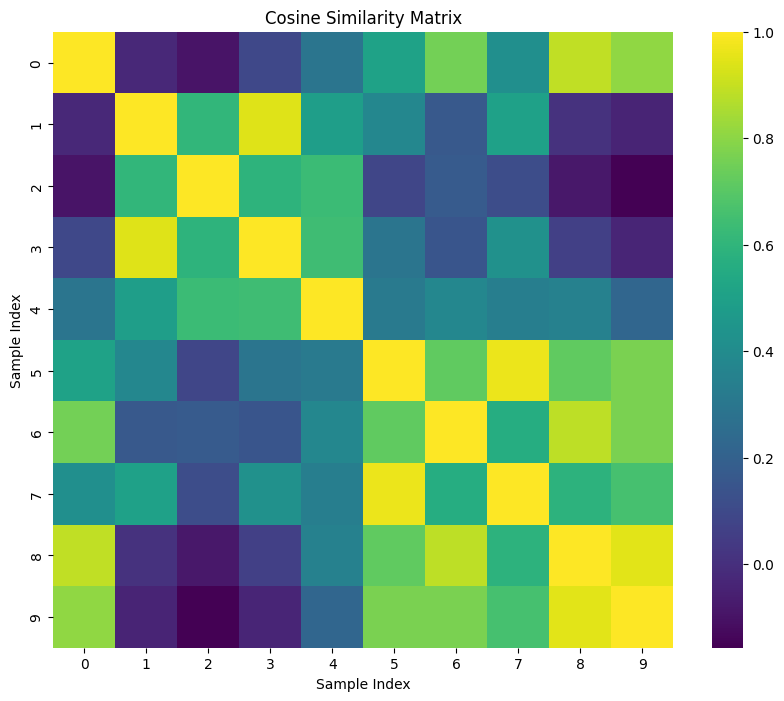

In [ ]:
"""
This class is a customized PyTorch Dataset class for contrastive self-supervised learning on tabular data.
It generates anchor-positive-negative triplets for each sample. The triplets contains:
- Anchor: the original input;
- Positive sample: augmented version of the anchor (if enabled);
- Negative sample: another randomly selected sample from the dataset.
This class applies randomly feature-wise augmentation (dropout, swap, and Gaussian noise) only to numerical features. Categorical features are masked during augmentation to avoid meaning loss..

Parameters:
- input_data: pd.DataFrame
  The input dataset containing the tabular data.
- augment: boolean
  If true, apply data augmentation to generate the positive sample.
  If false, use the original input as the positive sample.
- config: dictionary
  Augmentation configuration dictionary.
"""
class ListDataset(Dataset):
    def __init__(self, input_data, augment=False, config=None):
        self.data = input_data.values.astype("float32")
        self.augment = augment
        self.config = config

        # Extract the column index of the categorical features for masking in subsequent augmentation operations.
        self.categorical_indices = [input_data.columns.get_loc(col) for col in categorical_cols if col in input_data.columns]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        anchor = x.copy()
        positive = self.apply_augmentations(x.copy()) if self.augment else x.copy() # Depends on whether augment is true.
                                                  # If yes then perturb the sample and generate a positive; if not then make a copy..
        negative_idx = (idx + torch.randint(1, len(self.data), (1,)).item()) % len(self.data) # # Construct negative pairs. Select randomly another data as negative by randomly offsetting the index.
        negative = self.data[negative_idx].copy()

        return (
            # Convert to tensor. Use .unsqueeze(0) to ensure each output shape is (1, num_features) for easy batch processing.
            torch.tensor(anchor).unsqueeze(0),
            torch.tensor(positive).unsqueeze(0),
            torch.tensor(negative).unsqueeze(0)
        )

    def apply_augmentations(self, x):
        numeric_indices = [i for i in range(len(x)) if i not in self.categorical_indices] # Select numeric features for data augmentation only.
                                                        # Catagorical features might become meaningless after data augmentation and should be excluded from this procedure.

        # Randomly set a numerical feature to 0.
        if torch.rand(1).item() < self.config['aug_drop_prob'] and numeric_indices: # Make sure the numeric_indices is not None.
            drop_idx = random.choice(numeric_indices)
            x[drop_idx] = 0

        # If numOfNumericalFeatures >= 2 then randomely swap two features.
        if torch.rand(1).item() < self.config['aug_swap_prob'] and len(numeric_indices) >= 2:
            idx1, idx2 = random.sample(numeric_indices, 2)
            x[idx1], x[idx2] = x[idx2], x[idx1]

        # Add Gaussian noise
        noise = torch.randn(len(x)) * self.config['aug_noise_scale']
        noise[self.categorical_indices] = 0 # Avoid adding noise to catagorical features.
        x += noise.numpy()

        return x


"""
This class implements sinusoidal positional encoding as described in "Attention is All You Need" (Vaswani et al., 2017).
It adds positional information to input embeddings using a combination of sine and cosine functions with different frequencies across dimensions to help Transformer catch positional info.
It applies sine to even dimensions and cosine to odd dimensions with support of dropout for regularization.
It registers the positional info as a buffer, so it's not a trainable parameter but moves with the model across devices.

Parameters:
- d_model: int
 The embedding dimension.
- dropout: float
 The Dropout rate.
- max_len: int
 Maximum length of the input sequence this module can handle.

Example:
pe = PositionalEncoding(d_model=512)
output = pe(embedding_input)
"""
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)  # Add a Dropout layer to increase robustness.
        position = torch.arange(max_len).unsqueeze(1) # Creat position code.
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # Set the frequency factor to 1 / (10000 ** (2i / d_model)) (Vaswani et al., 2017).
                                                      # It produces an exponentially decreasing distribution from high to low frequencies.
                                                      # It makes Its role is to make different dimensions use different frequencies in the sin() and cos() functions so that the model can encode absolute and relative position information.

        # Store the positional information.
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe) # Register pe as a model buffer, It will not be updated by the optimizer but will be moved with the model to states such as .to(device) and .eval().

    def forward(self, x):

        # Add positional encoding.
        x = x + self.pe[:x.size(1)].transpose(0, 1)

        # Add Dropout and return.
        return self.dropout(x)

"""
This class implementes a transformer-based encoder for tabular data.
It aims to output embedded features that eases the downstream learning tasks with basic models.
This module follows a typical Transformer architecture which includes input embedding, positional encoding, projector, Transformer and normalization.

Parameters:
- input_dim: int
  Dimensionality of the input feature vector.
- d_model: int
  Model embedding dimension for the Transformer.
- nhead: int
  Number of attention heads.
- num_layers: int
  Number of stacked Transformer encoder layers.
- dim_feedforward: int
  Dimensionality of the feedforward network inside the Transformer.
- dropout: float
  The Dropout rate
- max_seq_len: int
  Maximum expected sequence length (for positional encoding).

Returns:
- The shape of the embedded features: (batch_size, seq_len, 64)
"""
class ListEncoder(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=4,
                 dim_feedforward=1024, dropout=0.1, max_seq_len=100):
        super(ListEncoder, self).__init__()
        self.d_model = d_model

        # Mapping the input, converts tabular row data into vector representation to fit the model dimension of the Transformer.
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model), # Layer normalization
            nn.ReLU() # Non-linearity
        )

        # Position Encoder
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_len)

        # Feature Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            activation='gelu', # GELU is "smarter" than ReLU and has a certain probability adjustment capability to express complex patterns.
            batch_first=True  # Allow (batch_size, seq_length, dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers) # Apply the above encoder layer many times in the encoder.
        self.output_norm = nn.LayerNorm(d_model) # Normalize the output.

        # Projector mapping the encoder output from the model dimension to the output dimension.
        self.projector = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, input):
        input = self.embedding(input) * math.sqrt(self.d_model) # Mapping and scaling
        input = self.pos_encoder(input) # Add position encoding
        output = self.transformer_encoder(input)  # Feed to the encoder
        output = self.output_norm(output) # Normalize the output.
        return self.projector(output)  # Mapping the output into the output dimension


def train_model(df, config):
    """
    This function trains the encoder model using contrastive learning with triplet loss, including the following steps:
    1. Initializes a ListEncoder (Transformer-based) model for tabular input;
    2. Construct a triplet dataset from the given DataFrame;
    3. Train the model using the TripletMarginLoss and optimize the model using AdamW optimizer.

    Parameters:
    - df: (pd.DataFrame)
      The input tabular data
    - config: dictionary
      The dictionary of training hyperparameters, including:
        batch_size(int): the batch size for training
        d_model(int): Transformer embedding dimension
        nhead(int): number of attention heads
        num_layers(int): number of encoder layers.
        dim_feedforward(int): the size of the hidden layers
        dropout(float): dropout rate in the model
        max_seq_len(int): maximum length of sequence for positional encoding.
        learning_rate(float): learning rate for optimizer
        weight_decay(float): L2 regularization strength
        epochs(int): number of training epochs

    Returns:
    - model (ListEncoder): The trained Transformer-based encoder model.
    """
    dataset = ListDataset(df, augment=True, config=config)
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True) # Use PyTorch's DataLoader to batch and shuffle the given dataset so that data can be loaded efficiently in batches when training the model.

    # Initialize the model.
    model = ListEncoder(
        input_dim=df.shape[1],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        dim_feedforward=config['dim_feedforward'],
        dropout=config['dropout'],
        max_seq_len=config['max_seq_len']
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Select device.
    model.to(device)  # Move the model to the device.

    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])  # Utilize AdamW which applies weight decay to Adam and helps stablize the training.
    criterion = nn.TripletMarginLoss(margin=1.0, p=2) # Triplet loss

    for epoch in range(config['epochs']):
        model.train()
        total_loss = 0

        for anchor, positive, negative in dataloader:

            # Encode the anchor, positive and negative.
            anchor = model(anchor.to(device)).squeeze(1)
            positive = model(positive.to(device)).squeeze(1)
            negative = model(negative.to(device)).squeeze(1)

            # Calculate loss and backpropagate.
            loss = criterion(anchor, positive, negative)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {total_loss / len(dataloader):.4f}")

    return model


def visualize_similarity(model, df, sample_size=100):
    """
    This function encodes the first 'sample_size' rows of the given DataFrame using the encoder,
    computes the pairwise cosine similarity matrix and displays it as a heatmap.

    Parameters:
    - model: torch.nn.Module
      The encoder
    - df: pd.DataFrame
      The input tabular data
    - sample_size: int
      The number of samples to visualize
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()

    # Extract the first several items (for visualization purposes) and convert them to tensor.
    X = df.iloc[:sample_size].values.astype('float32')
    X_tensor = torch.tensor(X).unsqueeze(1).to(device)

    # Encoding
    with torch.no_grad():
        encoded = model(X_tensor).squeeze(1).cpu().numpy()

    # Calculate similarity.
    sim_matrix = cosine_similarity(encoded)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, cmap='viridis')
    plt.title("Cosine Similarity Matrix")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.show()

# Hyperparameters of the encoder
config = {
    'input_dim': X_SSL_train.shape[1],
    'd_model': 256,
    'nhead': 8,
    'num_layers': 4,
    'dim_feedforward': 1024,
    'dropout': 0.1,
    'max_seq_len': 100,
    'batch_size': 64,
    'learning_rate': 3e-4,
    'weight_decay': 1e-5,
    'epochs': 30,
    'warmup_epochs': 5, # Gradually increase the learning rate to avoid drastic parameter updates in the early stage of training.
    'aug_drop_prob': 0.1,
    'aug_swap_prob': 0.2,
    'aug_noise_scale': 0.01,
}

model = train_model(X_SSL_train, config)
visualize_similarity(model, X_SSL_train, sample_size=10)

In [ ]:
"""
This code uses the trained model to encode the self-supervised features (train/test) and converts them into embedded vector representations for subsequent machine learning models.
"""
model.eval()

with torch.no_grad():
    # Convert the trainning and the testing set to tensor, and move them to the proper device.
    train_data = torch.tensor(X_SSL_train.values.astype("float32")).unsqueeze(1).to(next(model.parameters()).device)
    test_data = torch.tensor(X_SSL_test.values.astype("float32")).unsqueeze(1).to(next(model.parameters()).device)

    # Embedding
    X_train_embedded = model(train_data).squeeze(1).cpu().numpy()
    X_test_embedded = model(test_data).squeeze(1).cpu().numpy()

In [ ]:
"""
This function evaluates the performance of a trained model using test data and cross-validation results.
It accepts a fitted GridSearchCV or similar cross-validation object and performs the following:
1. Extracts and optionally formats the hyperparameter combinations.
2. Displays a table summarizing mean test scores for each parameter setting.
3. Identifies the best model from the search, makes predictions on the test set, and computes accuracy, macro-averaged precision and recall and AUC-ROC score using one-vs-rest (OVR) strategy for multiclass
4. Prints the best hyperparameter combination and a detailed classification report.

Parameters:
- search: GridSearchCV
  A trained GridSearchCV object containing cross-validation results.
- X_test: np.ndarray
    Feature matrix for the test set.
- y_test: np.ndarray
  Ground-truth labels for the test set.
- param_formatter: Callable[[pd.Series], str]
  A function that takes a row of the cv_results_ DataFrame and returns a formatted string for hyperparameter combinations.

Returns:
- acc: float
  Accuracy of the best hyperparameter combination on the test set
- auc: float
  AUC-ROC score of the best hyperparameter combination on the test set
"""

def evaluate_model_performance(search, X_test, y_test, param_formatter=None):
    results = pd.DataFrame(search.cv_results_)

    # Generate a readable string representation for each hyperparameter combination and stores it in the results['param_combo'] column for subsequent performance presentation
    if param_formatter:
        results['param_combo'] = results.apply(param_formatter, axis=1)
    else:
        results['param_combo'] = results['params'].astype(str)

    # Print performance table
    accuracy = results[['param_combo', 'mean_test_score']].copy()
    accuracy['mean_test_score'] = accuracy['mean_test_score'].round(5)
    print('\nPerformance of all hyperparameter combinations:')
    print(accuracy.to_string(index=False))

    # Evaluate best model
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    print('\nBest hyperparameter combination:', search.best_params_)
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC-ROC:", auc)
    print('\nClassification report:\n', classification_report(y_test, y_pred))

    return acc, auc

In [ ]:
"""
This script trains and evaluates a logistic regression model with and without SSL embeddings. It performs the following steps:
1. Defines a hyperparameter grid for logistic regression.
2. Performs grid search with 5-fold cross-validation.
3. Trains and evaluates the model twice and outputs accuracy and AUC-ROC scores for both settings.
"""

# Hyperparameters for logistic regression model
hyperparams_logistic_regression = {
    'penalty': ['l1', 'l2'],   # Regularization type
    'C': [0.01, 0.1, 1, 10],   # Regularization strength
    'solver': ['liblinear']    # Coordinate descent solver
}

# The grid search
search_logistic_regression = GridSearchCV(
    LogisticRegression(max_iter=500),
    param_grid=hyperparams_logistic_regression,
    cv=5, # 5-fold cross validation. Divide the dataset equally into 5 parts for 5 rounds of training and validation. Take the average score as the model performance.
    scoring='accuracy',
    refit=True, # Retrain with the best hyperparameters.
    n_jobs=-1   # Turn on all CPUs for parallelism.
)

# Cleanly format hyperparameter combinations for result display.
formatter_logistic_regression = lambda row: (
    f"penalty: {row['param_penalty']}, "
    f"C: {row['param_C']}, "
    f"solver: {row['param_solver']}"
)

# Train the logistic regression model without SSL encoder.
print("Training logistic regression model(without SSL encoder)...")
search_logistic_regression.fit(X_train, y_train)

acc_logistic_regression, auc_logistic_regression = evaluate_model_performance(search_logistic_regression, X_test, y_test, param_formatter=formatter_logistic_regression)

# Train the logistic regression model with SSL encoder.
print("\nTraining logistic regression model(with SSL encoder)...")
search_logistic_regression.fit(X_train_embedded, y_SSL_train)

acc_logistic_regression_with_SSL, auc_logistic_regression_with_SSL = evaluate_model_performance(search_logistic_regression, X_test_embedded, y_SSL_test, param_formatter=formatter_logistic_regression)

Training logistic regression model(without SSL encoder)...

Performance of all hyperparameter combinations:
                            param_combo  mean_test_score
penalty: l1, C: 0.01, solver: liblinear          0.91393
penalty: l2, C: 0.01, solver: liblinear          0.91425
 penalty: l1, C: 0.1, solver: liblinear          0.94163
 penalty: l2, C: 0.1, solver: liblinear          0.93130
 penalty: l1, C: 1.0, solver: liblinear          0.94398
 penalty: l2, C: 1.0, solver: liblinear          0.94101
penalty: l1, C: 10.0, solver: liblinear          0.93983
penalty: l2, C: 10.0, solver: liblinear          0.93842

Best hyperparameter combination: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9392991239048811
Precision: 0.9565055315055314
Recall: 0.8024563251161068
AUC-ROC: 0.9931069929193258

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.49      0.65       181
           1       0.92      0.93      0.92     

In [ ]:
"""
This script trains and evaluates a decision tree model with and without SSL embeddings. It performs the following steps:
1. Defines a hyperparameter grid for decision tree.
2. Performs grid search with 5-fold cross-validation.
3. Trains and evaluates the model twice and outputs accuracy and AUC-ROC scores for both settings.
"""

# Hyperparameters for decision tree model
hyperparams_decision_tree = {
    'criterion': ['gini', 'entropy', 'log_loss'],   # "Impurity" of a split
    'max_depth': [5, 10, 20, None],                 # Maximum depth of the decision tree
    'min_samples_split': [2, 5, 10],                # The minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]                   # The minimum number of samples required at a leaf node
}

# The grid search
search_decision_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=hyperparams_decision_tree,
    cv=5,
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)

# Cleanly format hyperparameter combinations for result display.
formatter_decision_tree = lambda row: (
    f"criterion: {row['param_criterion']}, "
    f"max_depth: {row['param_max_depth']}, "
    f"min_samples_split: {row['param_min_samples_split']}, "
    f"min_samples_leaf: {row['param_min_samples_leaf']}"
)


# Train the decision tree model without SSL encoder.
print("Training decision tree model(without SSL encoder)...")
search_decision_tree.fit(X_train, y_train)

acc_decision_tree, auc_decision_tree = evaluate_model_performance(search_decision_tree, X_test, y_test, param_formatter=formatter_decision_tree)

# Train the decision tree model with SSL encoder.
print("Training decision tree model(with SSL encoder)...")
search_decision_tree.fit(X_train_embedded, y_SSL_train)

acc_decision_tree_with_SSL, auc_decision_tree_with_SSL = evaluate_model_performance(search_decision_tree, X_test_embedded, y_SSL_test, param_formatter=formatter_decision_tree)

Training decision tree model(without SSL encoder)...

Performance of all hyperparameter combinations:
                                                                     param_combo  mean_test_score
        criterion: gini, max_depth: 5, min_samples_split: 2, min_samples_leaf: 1          0.94343
        criterion: gini, max_depth: 5, min_samples_split: 5, min_samples_leaf: 1          0.94343
       criterion: gini, max_depth: 5, min_samples_split: 10, min_samples_leaf: 1          0.94343
        criterion: gini, max_depth: 5, min_samples_split: 2, min_samples_leaf: 2          0.94343
        criterion: gini, max_depth: 5, min_samples_split: 5, min_samples_leaf: 2          0.94343
       criterion: gini, max_depth: 5, min_samples_split: 10, min_samples_leaf: 2          0.94343
        criterion: gini, max_depth: 5, min_samples_split: 2, min_samples_leaf: 4          0.94343
        criterion: gini, max_depth: 5, min_samples_split: 5, min_samples_leaf: 4          0.94343
       criterion

In [ ]:
"""
This script trains and evaluates a random forest model with and without SSL embeddings. It performs the following steps:
1. Defines a hyperparameter grid for random forest.
2. Performs grid search with 3-fold cross-validation.
3. Trains and evaluates the model twice and outputs accuracy and AUC-ROC scores for both settings.
"""

# Hyperparameters for decision random forest model
hyperparams_random_forest = {
    'n_estimators': [100, 200],     # The scale of the forest
    'max_depth': [10, 20, None],    # The depth of each tree
    'min_samples_split': [2, 5],    # The smallest number of samples before split
    'min_samples_leaf': [1, 2]      # The smallest number of samples each leaf.
}

# The grid search
search_random_forest = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=hyperparams_random_forest,
    cv=3, # Fewer folds than previous model to reduce training time.
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)

# Cleanly format hyperparameter combinations for result display.
formatter_random_forest = lambda row: (
    f"n_estimators: {row['param_n_estimators']}, "
    f"max_depth: {row['param_max_depth']}, "
    f"min_samples_split: {row['param_min_samples_split']}, "
    f"min_samples_leaf: {row['param_min_samples_leaf']}"
)

# Train the random forest model without SSL encoder.
print("Training random forest model(without SSL encoder)...")
search_random_forest.fit(X_train, y_train)

acc_random_forest, auc_random_forest = evaluate_model_performance(search_random_forest, X_test, y_test, param_formatter=formatter_random_forest)

# Train the random forest model with SSL encoder.
print("Training random forest model(with SSL encoder)...")
search_random_forest.fit(X_train_embedded, y_SSL_train)

acc_random_forest_with_SSL, auc_random_forest_with_SSL = evaluate_model_performance(search_random_forest, X_test_embedded, y_SSL_test, param_formatter=formatter_random_forest)

Training random forest model(without SSL encoder)...

Performance of all hyperparameter combinations:
                                                                  param_combo  mean_test_score
  n_estimators: 100, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1          0.72474
  n_estimators: 200, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1          0.66185
  n_estimators: 100, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1          0.79516
  n_estimators: 200, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1          0.70871
  n_estimators: 100, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2          0.70165
  n_estimators: 200, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2          0.64916
  n_estimators: 100, max_depth: 10, min_samples_split: 5, min_samples_leaf: 2          0.70807
  n_estimators: 200, max_depth: 10, min_samples_split: 5, min_samples_leaf: 2          0.68875
  n_estimators: 100, max_depth: 20, min_sam

In [ ]:
"""
This script trains and evaluates a XGBoost model with and without SSL embeddings. It performs the following steps:
1. Defines a hyperparameter grid for XGBoost.
2. Performs grid search with 3-fold cross-validation.
3. Trains and evaluates the model twice and outputs accuracy and AUC-ROC scores for both settings.
"""

# Hyperparameters for decision XGBoost model
hyperparams_XGBoost = {
    'n_estimators': [50, 100],  # The number of trees
    'max_depth': [3, 5],    # The depth of each tree
    'learning_rate': [0.05, 0.1], # The rate of contribution of each tree
    'subsample': [0.8, 1.0]     # Rate of subsampling
}

# The grid search
search_XGBoost = GridSearchCV(
    XGBClassifier(
    eval_metric='mlogloss',  # This suppresses some warnings.
    random_state=42),
    param_grid=hyperparams_XGBoost,
    cv=3, # Fewer folds than previous model to reduce training time.
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)

# Cleanly format hyperparameter combinations for result display.
formatter_XGBoost = lambda row: (
    f"n_estimators: {row['param_n_estimators']}, "
    f"max_depth: {row['param_max_depth']}, "
    f"learning_rate: {row['param_learning_rate']}, "
    f"subsample: {row['param_subsample']}"
)

# Train the XGBoost model without SSL encoder.
print("Training XGBoost model(without SSL encoder)...")
search_XGBoost.fit(X_train, y_train)

acc_XGBoost, auc_XGBoost = evaluate_model_performance(search_XGBoost, X_test, y_test, param_formatter=formatter_XGBoost)

# Train the random XGBoost with SSL encoder.
print("Training XGBoost model(with SSL encoder)...")
search_XGBoost.fit(X_train_embedded, y_SSL_train)

acc_XGBoost_with_SSL, auc_XGBoost_with_SSL = evaluate_model_performance(search_XGBoost, X_test_embedded, y_SSL_test, param_formatter=formatter_XGBoost)

Training XGBoost model(without SSL encoder)...


In [ ]:
"""Visualize the accuracy of the models with/without SSL encoder."""
accuracy_without_encoder = [acc_logistic_regression, acc_decision_tree, acc_random_forest, acc_XGBoost]
accuracy_with_encoder = [acc_logistic_regression_with_SSL, acc_decision_tree_with_SSL, acc_random_forest_with_SSL, acc_XGBoost_with_SSL]
accuracy_without_encoder = [x * 100 for x in accuracy_without_encoder]
accuracy_with_encoder = [x * 100 for x in accuracy_with_encoder]

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Position and width of the bars
x = np.arange(len(model_names))  # [0, 1, 2, 3]
bar_width = 0.35

# Create the bar chart for accuracy values.
fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - bar_width/2, accuracy_without_encoder, width=bar_width, color='lightskyblue', label='Without Encoder') # Bars for accuracy values without encoder
bars2 = ax.bar(x + bar_width/2, accuracy_with_encoder, width=bar_width, color='orange', label='With Encoder') # Bars for accuracy values with encoder

# Add labels.
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.8, f'{height:.1f}%', ha='center', va='bottom')

ax.set_title('Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

"""Visualize the AUG_ROC of the models with/without SSL encoder."""
AUG_ROC_without_encoder = [auc_logistic_regression, auc_decision_tree, auc_random_forest, auc_XGBoost]
AUG_ROC_with_encoder = [auc_logistic_regression_with_SSL, auc_decision_tree_with_SSL, auc_random_forest_with_SSL, auc_XGBoost_with_SSL]
AUG_ROC_without_encoder = [x * 100 for x in AUG_ROC_without_encoder]
AUG_ROC_with_encoder = [x * 100 for x in AUG_ROC_with_encoder]

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - bar_width/2, AUG_ROC_without_encoder, width=bar_width, color='lightskyblue', label='Without Encoder')
bars2 = ax.bar(x + bar_width/2, AUG_ROC_with_encoder, width=bar_width, color='orange', label='With Encoder')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.8, f'{height:.1f}%', ha='center', va='bottom')

ax.set_title('AUG_ROC')
ax.set_xlabel('Model')
ax.set_ylabel('')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 110) # A bit higher than 100 to make room for the labels on the bars
ax.legend()

plt.tight_layout()
plt.show()